In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
! git clone https://github.com/fransoa2607/bva.git

Cloning into 'bva'...
remote: Enumerating objects: 528, done.
remote: Counting objects: 100% (173/173), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 528 (delta 77), reused 135 (delta 51), pack-reused 355
Receiving objects: 100% (528/528), 100.31 MiB | 22.85 MiB/s, done.
Resolving deltas: 100% (282/282), done.


In [3]:
%env PYTHONPATH="$/env/python:/content/bva"
! echo $PYTHONPATH

env: PYTHONPATH="$/env/python:/content/bva"
"$/env/python:/content/bva"


In [4]:
cd ./bva/bva/

/content/bva/bva


In [7]:
from Tclass_model import classif_training

In [ ]:
model, history, test_dict = classif_training()

## Test classif

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
from Tclass_model import predict_classes
import pandas as pd

In [17]:
y_pred = predict_classes("/content/bva/bva/data/hitnet_match9_pred_final.csv",
                "/content/bva/bva/data/match9_1_07_11_predict.csv",
                "/content/bva/bva/data/match9_1_07_11_details.csv",
                "/content/bva/bva/data/match9_1_07_11_players.csv",
                "/content/bva/bva/models/2class")

In [18]:
pd.DataFrame(y_pred, columns=["att", "def"])

,att,def
0,9.999888e-01,1.121113e-05
1,9.947731e-01,5.226880e-03
2,7.560677e-05,9.999244e-01
3,3.681011e-09,1.000000e+00
4,9.999995e-01,4.249381e-07
5,9.934701e-01,6.529935e-03
6,9.999219e-01,7.809651e-05
7,9.999948e-01,5.260240e-06
8,2.089213e-12,1.000000e+00
9,5.434296e-03,9.945657e-01


## HITNET LEARNING

In [ ]:
from hitnet_model import hitnet_training, hitnet_predict_shots

In [ ]:
model, history, test_dict = hitnet_training()

Epoch 1/500
186/186 [==============================] - 8s 19ms/step - loss: 0.6639 - accuracy: 0.6100 - val_loss: 0.6524 - val_accuracy: 0.6425
Epoch 2/500
186/186 [==============================] - 3s 15ms/step - loss: 0.6477 - accuracy: 0.6140 - val_loss: 0.6255 - val_accuracy: 0.6505
Epoch 3/500
186/186 [==============================] - 3s 15ms/step - loss: 0.6075 - accuracy: 0.6587 - val_loss: 0.5683 - val_accuracy: 0.6922
Epoch 4/500
186/186 [==============================] - 3s 16ms/step - loss: 0.5565 - accuracy: 0.7001 - val_loss: 0.5182 - val_accuracy: 0.7554
Epoch 5/500
186/186 [==============================] - 3s 14ms/step - loss: 0.4323 - accuracy: 0.8100 - val_loss: 0.3662 - val_accuracy: 0.8320
Epoch 6/500
186/186 [==============================] - 3s 14ms/step - loss: 0.2816 - accuracy: 0.8863 - val_loss: 0.3278 - val_accuracy: 0.8669
Epoch 7/500
186/186 [==============================] - 3s 15ms/step - loss: 0.2290 - accuracy: 0.9136 - val_loss: 0.2351 - val_accuracy:

INFO:tensorflow:Assets written to: models/hitnet/assets


INFO:tensorflow:Assets written to: models/hitnet/assets


models/hitnet


## HITNET PREDICT

In [ ]:
from hitnet_model import hitnet_training, hitnet_predict_shots
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
y_pred = hitnet_predict_shots("/content/bva/bva/data/match2_1_00_02_predict.csv",
                       "/content/bva/bva/data/match2_1_00_02_details.csv",
                       "/content/bva/bva/data/match2_1_00_02_players.csv",
                       "/content/bva/bva/models/hitnet")

In [ ]:
df = pd.DataFrame(y_pred, columns=["0", "1"])
df.index.name = "index"
df

,0,1
index,,
0,0.871630,0.128370
1,0.000008,0.999992
2,0.000003,0.999997
3,0.000005,0.999995
4,0.000017,0.999983
...,...,...
592,0.999548,0.000452
593,0.999545,0.000455
594,0.999543,0.000457


In [ ]:
df.to_csv("/content/bva/bva/data/hitnet_match2_1_00_02_predict.csv")

In [ ]:
from analyze_predicts import find_final_predict_from_hitnet

In [ ]:
find_final_predict_from_hitnet("/content/bva/bva/data/hitnet_match2_1_00_02_predict.csv", 0.75)

,frame,hit
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
592,592,0
593,593,0
594,594,0
595,595,0


## FITTING

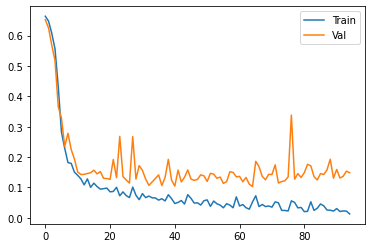

In [ ]:
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Val")
plt.legend();

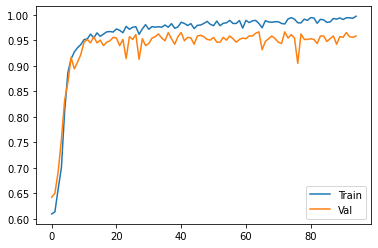

In [ ]:
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Val")
plt.legend();